# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Friends Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Friends script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximally distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **300 lines** of each character in the training data `training.csv` to create the training documents and a maximum of the first **30 lines** in the validation and test data (from `val.csv` and `test.csv`). This makes it more challenging, as the number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

In [ ]:
!pip install nltk

In [ ]:
!pip install spacy

In [ ]:
# !python -m spacy download en_core_web_md

In [ ]:
!pip install gender_guesser

In [ ]:
!pip install nlpaug

In [ ]:
!pip install nltk textblob

In [ ]:
!pip install textblob

In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

import nltk

import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nivesaratirupati/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nivesaratirupati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nivesaratirupati/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/nivesaratirupati/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/nivesaratirupati/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


In [ ]:
def create_character_document_from_dataframe(df, max_line_count, context_size=5):
    """
    Returns a dict with the name of the character as key, their lines and a limited context of lines
    from other characters in the same scene joined together as a single string.
    """
    character_docs = {}
    character_line_count = {}

    # Group by episode and scene
    grouped = df.groupby(['Episode', 'Scene'])
    for (episode, scene), group in grouped:

        # Iterate over each character in the scene
        for name, line_group in group.dropna(subset=['Line']).groupby('Character_name'):
            if name not in character_docs:
                character_docs[name] = ""
                character_line_count[name] = 0

            if character_line_count[name] >= max_line_count:
                continue

            for idx in line_group.index:
                # Get context lines (limited by context_size)
                # Ensure the context is from the same scene and does not include the character's own lines
                context_before = group.loc[(group.index < idx) & (group['Character_name'] != name)].tail(context_size)['Line'].dropna().astype(str).tolist()
                context_after = group.loc[(group.index > idx) & (group['Character_name'] != name)].head(context_size)['Line'].dropna().astype(str).tolist()
                context = " EOL ".join(context_before + context_after)

                # Combine character's own lines with context
                character_lines = " EOL ".join(line_group.loc[idx].astype(str).tolist())
                character_docs[name] += character_lines + " CONTEXT_START " + context + " CONTEXT_END "
                character_line_count[name] += len(line_group.loc[idx])

    print("lines per character", character_line_count)
    return character_docs

In [ ]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
Num. Characters:  10 

#ALL# Number of Words:  6851
Chandler Bing Number of Words:  7944
Joey Tribbiani Number of Words:  7389
Monica Geller Number of Words:  6824
Other_None Number of Words:  5271
Phoebe Buffay Number of Words:  6170
Rachel Green Number of Words:  8359
Ross Geller Number of Words:  6923
Other_Female Number of Words:  6877
Other_Male Number of Words:  5808
total words 68416


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')

def pre_process(character_text):

    character_text = character_text.lower()

    # Removing extra spaces
    character_text = re.sub(r'\s+', ' ', character_text).strip()

    # Tokenization (including removing punctuation)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(character_text)
    # Remove numbers
    tokens = [re.sub(r'\d', '', token) for token in tokens]

    # Stemming using PorterStemmer
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]


    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]


    # Lemmatization using WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]


    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nivesaratirupati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [ ]:
from collections import Counter
from nltk import ngrams, word_tokenize, pos_tag
from textblob import TextBlob
import gender_guesser.detector as gender


def extract_ngrams(tokens, n):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

def to_feature_vector_dictionary(character_doc):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Improved version with bigrams, unigrams, POS tags, gender prediction, and sentiment analysis.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    # Token counts
    counts = Counter(character_doc)

    # N-grams (unigrams, bigrams, and trigrams)
    for n in range(1, 5):
        ngram_features = extract_ngrams(character_doc, n)
        ngram_counts = Counter(ngram_features)
        counts.update(ngram_counts)

    # POS tags
    pos_tags = pos_tag(word_tokenize(' '.join(character_doc)))
    pos_counts = Counter(tag for word, tag in pos_tags)
    counts.update(pos_counts)


    # Sentiment Analysis
    sentiment = TextBlob(' '.join(character_doc)).sentiment
    counts['sentiment_polarity'] = sentiment.polarity
    counts['sentiment_subjectivity'] = sentiment.subjectivity

    return counts

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction import DictVectorizer

# Initialize the vectorizer and TF-IDF transformer
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False, feature_selection_k=None):

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        # Fit the DictVectorizer
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])

    # Transform to feature matrix
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])

    # TF-IDF transformation
    doc_feature_matrix_tfidf = tfidf_transformer.fit_transform(doc_feature_matrix)

    # Feature selection
    if feature_selection_k is not None:
        labels = [label for label, doc in corpus]
        feature_selector = SelectKBest(chi2, k=feature_selection_k)
        doc_feature_matrix_tfidf = feature_selector.fit_transform(doc_feature_matrix_tfidf, labels)

    return doc_feature_matrix_tfidf

# Example usage
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_selection_k=None)

In [ ]:
training_feature_matrix

<10x28105 sparse matrix of type '<class 'numpy.float64'>'
	with 56598 stored elements in Compressed Sparse Row format>

In [ ]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
Num. Characters:  10 

Other_None Num of Words:  582
Rachel Green Num of Words:  1032
Other_Male Num of Words:  777
#ALL# Num of Words:  617
Chandler Bing Num of Words:  808
Joey Tribbiani Num of Words:  694
Monica Geller Num of Words:  998
Phoebe Buffay Num of Words:  654
Ross Geller Num of Words:  817
Other_Female Num of Words:  771
total words 7750


In [ ]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [ ]:
val_feature_matrix

<10x28105 sparse matrix of type '<class 'numpy.float64'>'
	with 2164 stored elements in Compressed Sparse Row format>

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.0
mean cosine similarity 0.8950796459969229
10 correct out of 10 / accuracy: 1.0


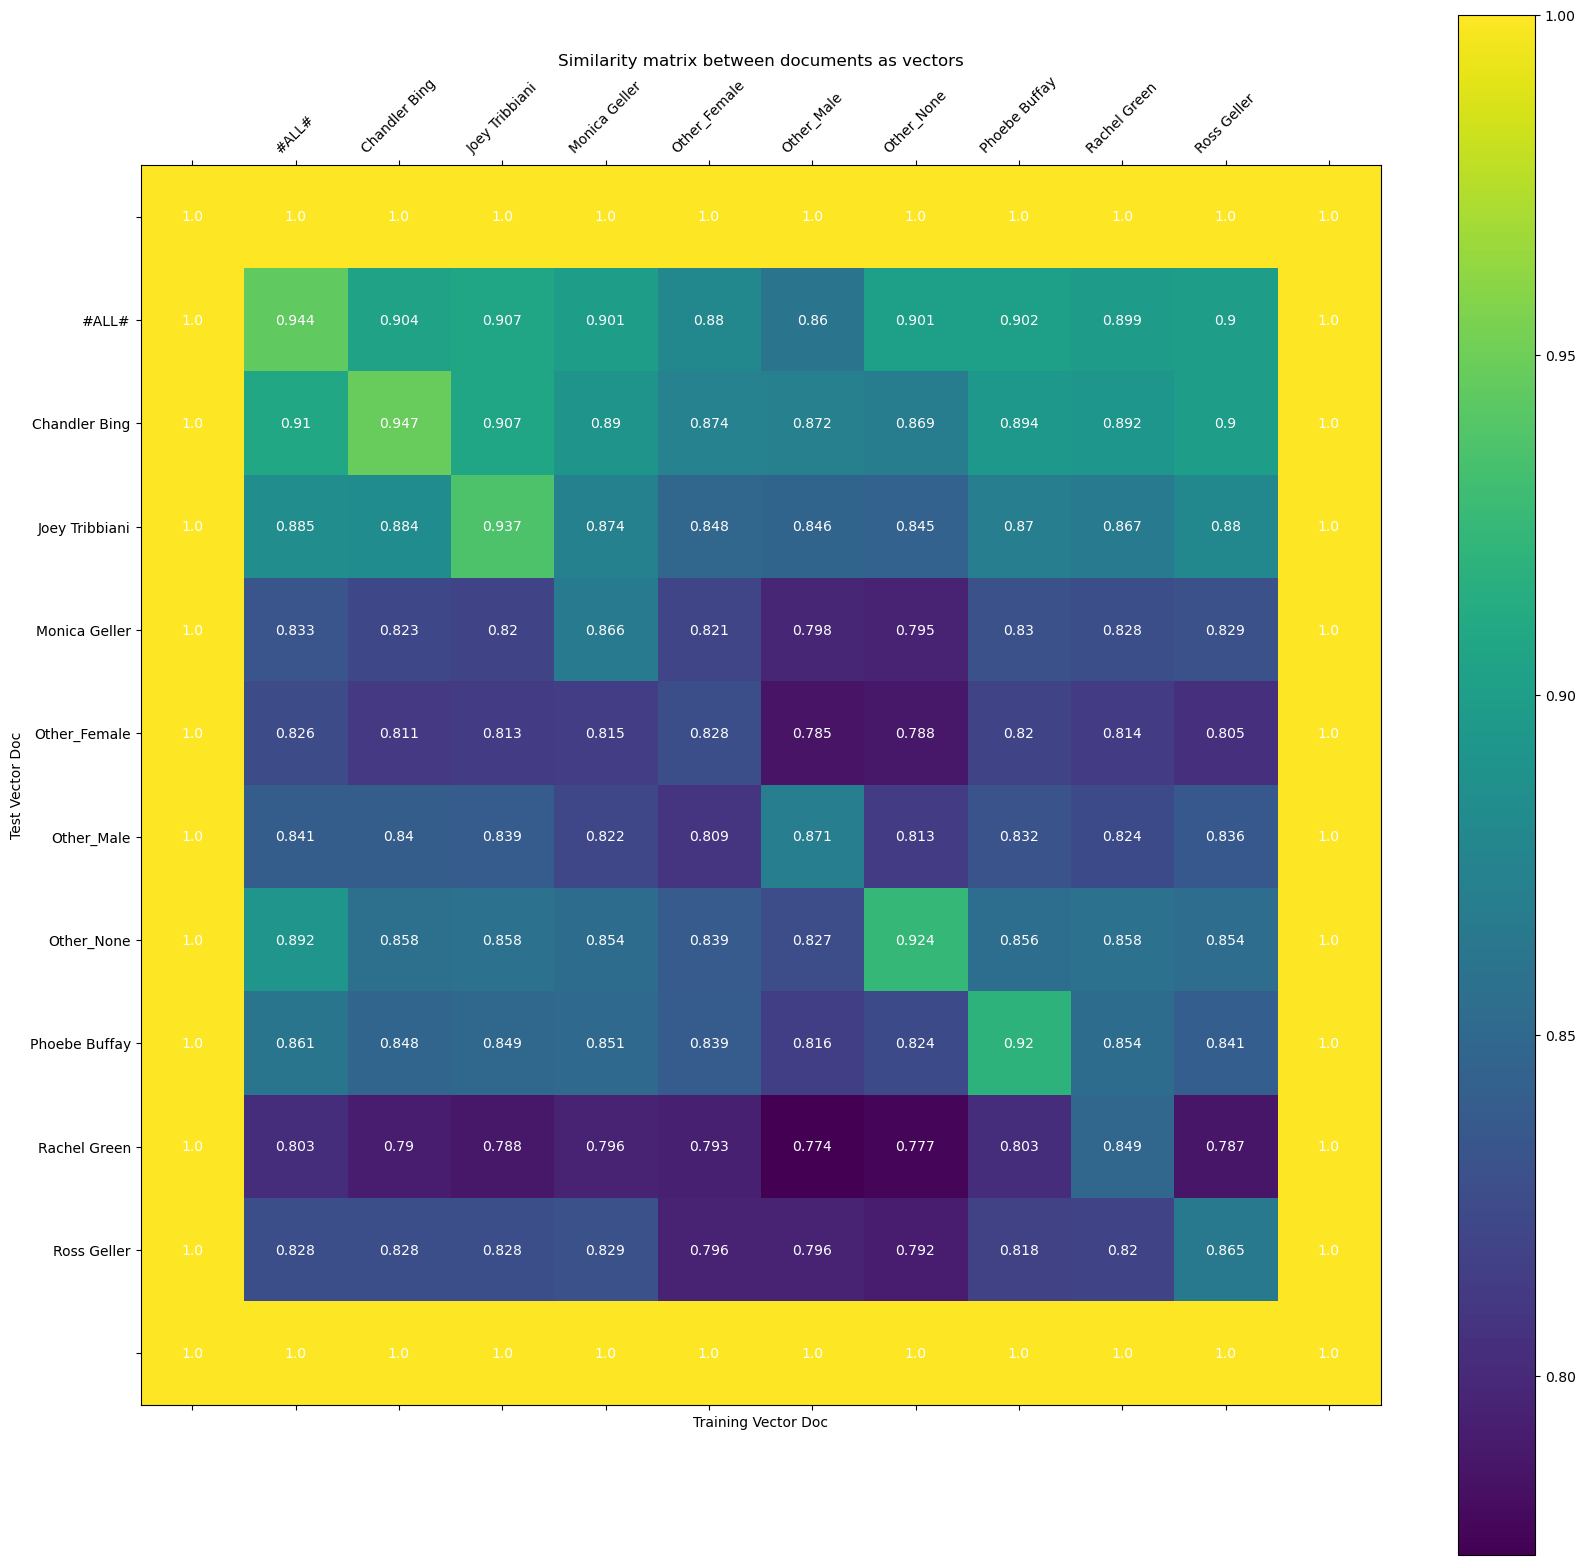

In [ ]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 30 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **10**. Initially, the code in this template achieves a mean rank of **4.0**  and accuracy of **0.3** on the test set and a mean rank of **4.2** and accuracy of **0.1** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html.

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

In [ ]:
from itertools import product

In [ ]:
def pre_process(character_text, args):
    """
    Pre-process the input text based on different combinations of arguments.

    :param character_text: a string with all of one character's lines
    :param arg_combinations: a list of tuples representing combinations of arguments
                             e.g., [(True, True, True), (False, True, False), ...]
    :return: a list of tokens for each combination
    """
    result_tokens = []


    # Initialize tokens before applying processing steps
    tokens = word_tokenize(character_text)

    arg_1, arg_2, arg_3 = args

    if arg_1:
        character_text = character_text.lower()
        # Removing extra spaces
        character_text = re.sub(r'\s+', ' ', character_text).strip()
        # Tokenization (including removing punctuation)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(character_text)
        # Stemming using PorterStemmer
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    if arg_2:
        # Remove numbers
        tokens = [re.sub(r'\d', '', token) for token in tokens]

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token.lower() not in stop_words]

    if arg_3:
        # Lemmatization using WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    result_tokens.extend(tokens)

    return result_tokens

In [ ]:
from itertools import product

# Assuming the functions and variables required are defined elsewhere in your code

arg_combinations = list(product([True, False], [True, False], [True, False]))
best_mean_rank = float('inf')  # Assuming you want to minimize mean_rank

for args in arg_combinations:
    # Redo on training data with the first 300 character lines used
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
    training_corpus = [(name, pre_process(doc, args)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]

    # Check if there are valid feature vectors
    if not any(training_corpus):
        continue

    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True, feature_selection_k=None)

    # Get the test data using 30 lines per character
    test_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
    test_corpus = [(name, pre_process(doc, args)) for name, doc in sorted(test_character_docs.items())]
    test_labels = [name for name, doc in test_corpus]

    # Check if there are valid feature vectors
    if not any(test_corpus):
        continue

    test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False, feature_selection_k=None)

    # Compute evaluation scores on the final test data
    mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

    # Update the best combination if the current mean rank is better
    if mean_rank < best_mean_rank:
        best_mean_rank = mean_rank
        best_arg_combination = args

# Example usage
print("Best Argument Combination:", best_arg_combination)

lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
mean rank 1.0
mean cosine similarity 0.8950796459969229
10 correct out of 10 / accuracy: 1.0
lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
mean rank 1.0
mean cosine simil

In [ ]:
def to_feature_vector_dictionary(character_doc, args):

    arg_4, arg_5, arg_6 = args

    # Token counts
    counts = Counter(character_doc)

    # N-grams (unigrams, bigrams, and trigrams)
    if arg_4:
        for n in range(1, 2):
            # Count occurrences of n-grams
            ngram_features = extract_ngrams(character_doc, n)
            ngram_counts = Counter(ngram_features)

            # Convert counts to integers
            ngram_counts = {key: int(value) for key, value in ngram_counts.items()}
            counts.update(ngram_counts)

    if arg_5:
        # Sentiment Analysis
        sentiment = TextBlob(' '.join(character_doc)).sentiment
        counts['sentiment_polarity'] = sentiment.polarity
        counts['sentiment_subjectivity'] = sentiment.subjectivity

    if arg_6:
        # POS tags
        pos_tags = pos_tag(word_tokenize(' '.join(character_doc)))
        pos_counts = Counter(tag for word, tag in pos_tags)
        counts.update(pos_counts)


    return counts



In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction import DictVectorizer

# Initialize the vectorizer and TF-IDF transformer
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False, feature_selection_k=None):

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        # Fit the DictVectorizer
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, args) for name, doc in corpus])

    # Transform to feature matrix
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, args) for name, doc in corpus])

    # TF-IDF transformation
    doc_feature_matrix_tfidf = tfidf_transformer.fit_transform(doc_feature_matrix)

    # Feature selection
    if feature_selection_k is not None:
        labels = [label for label, doc in corpus]
        feature_selector = SelectKBest(chi2, k=feature_selection_k)
        doc_feature_matrix_tfidf = feature_selector.fit_transform(doc_feature_matrix_tfidf, labels)

    return doc_feature_matrix_tfidf

In [ ]:
arg_combinations = list(product([True, False], [True, False], [True, False]))
best_mean_rank = 10
for args in arg_combinations:
    # redo on training data with the first 300 character lines used
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)

    training_corpus = [(name, to_feature_vector_dictionary(doc, args)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]

    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

     # Get the test data using 30 lines per character
    test_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)

    test_corpus = [(name, to_feature_vector_dictionary(doc, args)) for name, doc in sorted(test_character_docs.items())]
    test_labels = [name for name, doc in test_corpus]


    test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

    mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)
    # Update the best combination if the current mean rank is better
    if mean_rank < best_mean_rank:
        best_mean_rank = mean_rank
        best_arg_combination = args

# Example usage
# best_args = perform_grid_search(train_character_docs, val_character_docs)
print("Best Argument Combination:", best_arg_combination)

lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
mean rank 2.4
mean cosine similarity 0.9926279316197094
6 correct out of 10 / accuracy: 0.6
lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
lines per character {'Other_None': 40, 'Rachel Green': 55, 'Other_Male': 55, '#ALL#': 35, 'Chandler Bing': 40, 'Joey Tribbiani': 40, 'Monica Geller': 55, 'Phoebe Buffay': 45, 'Ross Geller': 45, 'Other_Female': 35}
mean rank 2.1
mean cosine simila

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction import DictVectorizer

# Initialize the vectorizer and TF-IDF transformer
corpusVectorizer = DictVectorizer()
tfidf_transformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=False):

    # Extract feature vectors for the corpus
    feature_dicts = [to_feature_vector_dictionary(doc, tfidf_params) for name, doc in corpus]

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        # Fit the DictVectorizer
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, args) for name, doc in corpus])

    # Transform to feature matrix
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, args) for name, doc in corpus])

    # TF-IDF transformation
    doc_feature_matrix_tfidf = tfidf_transformer.fit_transform(doc_feature_matrix)

    return doc_feature_matrix_tfidf

In [ ]:
from itertools import product
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer



tfidf_params = {
    'max_df': 0.85,  # Ignore terms that appear in more than 85% of the documents
    'min_df': 2,     # Ignore terms that appear in fewer than 2 documents
    'stop_words': 'english',    # Apply sublinear TF scaling (logarithmic scaling) to term frequencies
}


# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(**tfidf_params)

# Define additional parameters to search for character document creation
character_doc_param_grid = {
    'max_line_count': [100, 200, 300],
    'context_size': [3, 5, 7]
}

best_overall_performance = float('-inf')
best_overall_params = {}
train_character_names = set(train_data['Character_name'].unique())
val_character_names = set(val_data['Character_name'].unique())

# Iterate over all combinations of parameters from the character_doc_param_grid
for character_doc_params in ParameterGrid(character_doc_param_grid):
    # Create character documents with the current parameters
    character_docs = create_character_document_from_dataframe(train_data, **character_doc_params)

    # Pre-process documents
    train_processed_docs = {name: pre_process(doc, args) for name, doc in character_docs.items() if name in train_character_names}
    val_processed_docs = {name: pre_process(doc, args) for name, doc in character_docs.items() if name in val_character_names}

    # Create training and validation corpus
    train_corpus = [(name, doc) for name, doc in train_processed_docs.items()]
    val_corpus = [(name, doc) for name, doc in val_processed_docs.items()]

    # Create document matrices
    training_feature_matrix = create_document_matrix_from_corpus(train_corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=True)
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=False)

    # Compute evaluation scores
    mean_rank, mean_cosine_similarity, accuracy, _ = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

    # Determine the best performing parameters
    if accuracy > best_overall_performance:
        best_overall_performance = accuracy
        best_overall_params = {'Best_parameters': character_doc_params}

# Output the best performing parameters
print("Best Overall Parameters:", best_overall_params)

lines per character {'#ALL#': 105, 'Chandler Bing': 120, 'Joey Tribbiani': 110, 'Monica Geller': 135, 'Other_None': 115, 'Phoebe Buffay': 100, 'Rachel Green': 120, 'Ross Geller': 105, 'Other_Female': 115, 'Other_Male': 125}
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
lines per character {'#ALL#': 210, 'Chandler Bing': 205, 'Joey Tribbiani': 215, 'Monica Geller': 255, 'Other_None': 230, 'Phoebe Buffay': 225, 'Rachel Green': 225, 'Ross Geller': 220, 'Other_Female': 210, 'Other_Male': 205}
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
mean rank 1.0
mean cosine similarity 1.0
10 correct out of 10 / accuracy: 1.0
lines per character {'#ALL#': 105, 'Chandler Bing': 120, 'Joey Tribbiani': 110, 'Monica Geller

# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

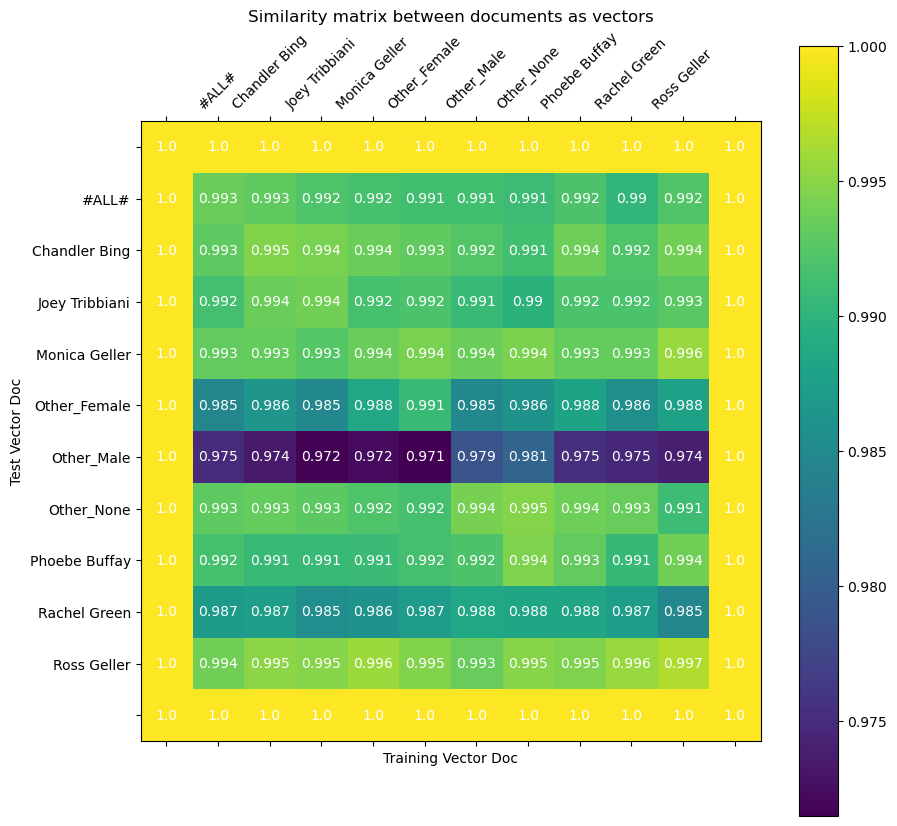

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()
plot_heat_map_similarity(df)

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 30 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [ ]:
# redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc, args=(True, True, True))) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(train_corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc, args=(True, True, True))) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(train_corpus, tfidf_vectorizer, corpusVectorizer, tfidf_transformer, tfidf_params, fitting=True)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'#ALL#': 300, 'Chandler Bing': 355, 'Joey Tribbiani': 315, 'Monica Geller': 305, 'Other_None': 320, 'Phoebe Buffay': 300, 'Rachel Green': 355, 'Ross Geller': 315, 'Other_Female': 340, 'Other_Male': 305}
Num. Characters:  10 

#ALL# Number of Words:  6851
Chandler Bing Number of Words:  7944
Joey Tribbiani Number of Words:  7389
Monica Geller Number of Words:  6824
Other_None Number of Words:  5271
Phoebe Buffay Number of Words:  6170
Rachel Green Number of Words:  8359
Ross Geller Number of Words:  6923
Other_Female Number of Words:  6877
Other_Male Number of Words:  5808
total words 68416
lines per character {'Chandler Bing': 55, 'Joey Tribbiani': 30, 'Ross Geller': 60, '#ALL#': 30, 'Other_Female': 55, 'Other_None': 30, 'Monica Geller': 85, 'Phoebe Buffay': 40, 'Rachel Green': 30, 'Other_Male': 35}
Num. Characters:  10 

Chandler Bing Number of Words:  1144
Joey Tribbiani Number of Words:  667
Ross Geller Number of Words:  1220
#ALL# Number of Words:  545
Other_Fe